In [10]:
import plotly.express as px
import numpy as np
# Prepare the data (here we're using a simple example with a dataset of iris flowers)
df = px.data.iris()

In [14]:
df

,sepal_length,sepal_width,petal_length,petal_width,species,species_id
0,5.1,3.5,1.4,0.2,setosa,1
1,4.9,3.0,1.4,0.2,setosa,1
2,4.7,3.2,1.3,0.2,setosa,1
3,4.6,3.1,1.5,0.2,setosa,1
4,5.0,3.6,1.4,0.2,setosa,1
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica,3
146,6.3,2.5,5.0,1.9,virginica,3
147,6.5,3.0,5.2,2.0,virginica,3
148,6.2,3.4,5.4,2.3,virginica,3


In [15]:
# Create a scatter plot
df_np = np.array(df[["sepal_width","sepal_length"]])
fig = px.scatter(df_np[:,0],df_np[:,1])

# Show the plot
fig.show()

In [16]:
import torch

# Create a sample tensor with shape (4, 22)
data = torch.arange(12).view(4, 3)

# Check your original data
print("Original data:")
print(data)

# Use repeat_interleave to repeat each element in the array 3 times along the specified dimension
repeated_data = data.repeat_interleave(3, dim=1)

# Check the shape and contents of the new tensor
print("\nNew shape:", repeated_data.shape)
print("Repeated data:")
print(repeated_data)

Original data:
tensor([[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8],
        [ 9, 10, 11]])

New shape: torch.Size([4, 9])
Repeated data:
tensor([[ 0,  0,  0,  1,  1,  1,  2,  2,  2],
        [ 3,  3,  3,  4,  4,  4,  5,  5,  5],
        [ 6,  6,  6,  7,  7,  7,  8,  8,  8],
        [ 9,  9,  9, 10, 10, 10, 11, 11, 11]])


In [21]:
data_rand = torch.rand((3,4))-0.5
print(data_rand)
print(torch.norm(data_rand.to(torch.float32),p=1))

tensor([[ 0.3484,  0.0988, -0.3650,  0.0899],
        [-0.3191, -0.1855,  0.1353,  0.2979],
        [ 0.0826,  0.0132, -0.4637,  0.4103]])
tensor(2.8098)


In [59]:
from math import pi, log

import torch
from torch import nn, einsum

from einops import rearrange, repeat

# helper functions

def exists(val):
    return val is not None

def default(val, d):
    return val if exists(val) else d

def broadcat(tensors, dim = -1):
    num_tensors = len(tensors)
    shape_lens = set(list(map(lambda t: len(t.shape), tensors)))
    assert len(shape_lens) == 1, 'tensors must all have the same number of dimensions'
    shape_len = list(shape_lens)[0]

    dim = (dim + shape_len) if dim < 0 else dim
    dims = list(zip(*map(lambda t: list(t.shape), tensors)))

    expandable_dims = [(i, val) for i, val in enumerate(dims) if i != dim]
    assert all([*map(lambda t: len(set(t[1])) <= 2, expandable_dims)]), 'invalid dimensions for broadcastable concatentation'
    max_dims = list(map(lambda t: (t[0], max(t[1])), expandable_dims))
    expanded_dims = list(map(lambda t: (t[0], (t[1],) * num_tensors), max_dims))
    expanded_dims.insert(dim, (dim, dims[dim]))
    expandable_shapes = list(zip(*map(lambda t: t[1], expanded_dims)))
    tensors = list(map(lambda t: t[0].expand(*t[1]), zip(tensors, expandable_shapes)))
    return torch.cat(tensors, dim = dim)

# rotary embedding helper functions

def rotate_half(x):
    x = rearrange(x, '... (d r) -> ... d r', r = 2)
    x1, x2 = x.unbind(dim = -1)
    x = torch.stack((-x2, x1), dim = -1)
    return rearrange(x, '... d r -> ... (d r)')

def apply_rotary_emb(freqs, t, start_index = 0, scale = 1., seq_dim = -2):
    rot_dim, seq_len = freqs.shape[-1], t.shape[seq_dim]
    freqs = freqs[-seq_len:].to(t)

    end_index = start_index + rot_dim
    assert rot_dim <= t.shape[-1], f'feature dimension {t.shape[-1]} is not of sufficient size to rotate in all the positions {rot_dim}'
    t_left, t, t_right = t[..., :start_index], t[..., start_index:end_index], t[..., end_index:]
    t = (t * freqs.cos() * scale) + (rotate_half(t) * freqs.sin() * scale)
    return torch.cat((t_left, t, t_right), dim = -1)

# learned rotation helpers

def apply_learned_rotations(rotations, t, start_index = 0, freq_ranges = None):
    if exists(freq_ranges):
        rotations = einsum('..., f -> ... f', rotations, freq_ranges)
        rotations = rearrange(rotations, '... r f -> ... (r f)')

    rotations = repeat(rotations, '... n -> ... (n r)', r = 2)
    return apply_rotary_emb(rotations, t, start_index = start_index)

# classes

class RotaryEmbedding(nn.Module):
    def __init__(
        self,
        dim,
        custom_freqs = None,
        freqs_for = 'lang',
        theta = 10000,
        max_freq = 10,
        num_freqs = 1,
        learned_freq = False,
        use_xpos = False,
        xpos_scale_base = 512,
        interpolate_factor = 1.,
        theta_rescale_factor = 1.,
        seq_before_head_dim = False
    ):
        super().__init__()
        # proposed by reddit user bloc97, to rescale rotary embeddings to longer sequence length without fine-tuning
        # has some connection to NTK literature
        # https://www.reddit.com/r/LocalLLaMA/comments/14lz7j5/ntkaware_scaled_rope_allows_llama_models_to_have/

        theta *= theta_rescale_factor ** (dim / (dim - 2))

        if exists(custom_freqs):
            freqs = custom_freqs
        elif freqs_for == 'lang':
            freqs = 1. / (theta ** (torch.arange(0, dim, 2)[:(dim // 2)].float() / dim))
        elif freqs_for == 'pixel':
            freqs = torch.linspace(1., max_freq / 2, dim // 2) * pi
        elif freqs_for == 'constant':
            freqs = torch.ones(num_freqs).float()
        else:
            raise ValueError(f'unknown modality {freqs_for}')

        self.cache = dict()
        self.cache_scale = dict()
        self.freqs = nn.Parameter(freqs, requires_grad = learned_freq)

        # default sequence dimension

        self.seq_before_head_dim = seq_before_head_dim
        self.default_seq_dim = -3 if seq_before_head_dim else -2

        # interpolation factors

        assert interpolate_factor >= 1.
        self.interpolate_factor = interpolate_factor

        # xpos

        self.use_xpos = use_xpos
        if not use_xpos:
            self.register_buffer('scale', None)
            return

        scale = (torch.arange(0, dim, 2) + 0.4 * dim) / (1.4 * dim)
        self.scale_base = xpos_scale_base
        self.register_buffer('scale', scale)

    def get_seq_pos(self, seq_len, device, dtype, offset = 0):
        return (torch.arange(seq_len, device = device, dtype = dtype) + offset) / self.interpolate_factor

    def rotate_queries_or_keys(self, t, seq_dim = None, offset = 0, freq_seq_len = None):
        seq_dim = default(seq_dim, self.default_seq_dim)

        assert not self.use_xpos, 'you must use `.rotate_queries_and_keys` method instead and pass in both queries and keys, for length extrapolatable rotary embeddings'

        device, dtype, seq_len = t.device, t.dtype, t.shape[seq_dim]

        if exists(freq_seq_len):
            assert freq_seq_len >= seq_len
            seq_len = freq_seq_len

        freqs = self.forward(lambda: self.get_seq_pos(seq_len, device = device, dtype = dtype, offset = offset), cache_key = f'freqs:{seq_len}|offset:{offset}')

        if seq_dim == -3:
            freqs = rearrange(freqs, 'n d -> n 1 d')
        print(freqs[2])
        return apply_rotary_emb(freqs, t, seq_dim = seq_dim)

    def rotate_queries_with_cached_keys(self, q, k, seq_dim = None, offset = 0):
        seq_dim = default(seq_dim, self.default_seq_dim)

        q_len, k_len = q.shape[seq_dim], k.shape[seq_dim]
        assert q_len <= k_len
        rotated_q = self.rotate_queries_or_keys(q, seq_dim = seq_dim, freq_seq_len = k_len)
        rotated_k = self.rotate_queries_or_keys(k, seq_dim = seq_dim)

        rotated_q = rotated_q.type(q.dtype)
        rotated_k = rotated_k.type(k.dtype)

        return rotated_q, rotated_k

    def rotate_queries_and_keys(self, q, k, seq_dim = None):
        seq_dim = default(seq_dim, self.default_seq_dim)

        assert self.use_xpos
        device, dtype, seq_len = q.device, q.dtype, q.shape[seq_dim]

        seq = self.get_seq_pos(seq_len, dtype = dtype, device = device)
        freqs = self.forward(lambda: seq, cache_key = f'freqs:{seq_len}')
        scale = self.get_scale(lambda: seq, cache_key = f'scale:{seq_len}').to(dtype)

        if seq_dim == -3:
            freqs = rearrange(freqs, 'n d -> n 1 d')
            scale = rearrange(scale, 'n d -> n 1 d')

        rotated_q = apply_rotary_emb(freqs, q, scale = scale, seq_dim = seq_dim)
        rotated_k = apply_rotary_emb(freqs, k, scale = scale ** -1, seq_dim = seq_dim)

        rotated_q = rotated_q.type(q.dtype)
        rotated_k = rotated_k.type(k.dtype)

        return rotated_q, rotated_k

    def get_scale(self, t, cache_key = None):
        assert self.use_xpos

        if exists(cache_key) and cache_key in self.cache:
            return self.cache[cache_key]

        if callable(t):
            t = t()

        scale = 1.
        if self.use_xpos:
            power = (t - len(t) // 2) / self.scale_base
            scale = self.scale ** rearrange(power, 'n -> n 1')
            scale = torch.cat((scale, scale), dim = -1)

        if exists(cache_key):
            self.cache[cache_key] = scale

        return scale

    def forward(self, t, cache_key = None):
        if exists(cache_key) and cache_key in self.cache:
            return self.cache[cache_key]

        if callable(t):
            t = t()

        freqs = self.freqs

        freqs = einsum('..., f -> ... f', t.type(freqs.dtype), freqs)
        freqs = repeat(freqs, '... n -> ... (n r)', r = 2)

        if exists(cache_key):
            self.cache[cache_key] = freqs

        return freqs

In [60]:
rotary_emb = RotaryEmbedding(dim = 32)

# mock queries and keys - dimensions should end with (seq_len, feature dimension), and any number of preceding dimensions (batch, heads, etc)

q_ori = torch.randn(1, 8, 1024, 64) # queries - (batch, heads, seq len, dimension of head)
k_ori = torch.randn(1, 8, 1024, 64) # keys

# apply the rotations to your queries and keys after the heads have been split out, but prior to the dot product and subsequent softmax (attention)

q = rotary_emb.rotate_queries_or_keys(q)
k = rotary_emb.rotate_queries_or_keys(k)

print(q.shape)

tensor([2.0000e+00, 2.0000e+00, 1.1247e+00, 1.1247e+00, 6.3246e-01, 6.3246e-01,
        3.5566e-01, 3.5566e-01, 2.0000e-01, 2.0000e-01, 1.1247e-01, 1.1247e-01,
        6.3246e-02, 6.3246e-02, 3.5566e-02, 3.5566e-02, 2.0000e-02, 2.0000e-02,
        1.1247e-02, 1.1247e-02, 6.3246e-03, 6.3246e-03, 3.5566e-03, 3.5566e-03,
        2.0000e-03, 2.0000e-03, 1.1247e-03, 1.1247e-03, 6.3246e-04, 6.3246e-04,
        3.5566e-04, 3.5566e-04])
tensor([2.0000e+00, 2.0000e+00, 1.1247e+00, 1.1247e+00, 6.3246e-01, 6.3246e-01,
        3.5566e-01, 3.5566e-01, 2.0000e-01, 2.0000e-01, 1.1247e-01, 1.1247e-01,
        6.3246e-02, 6.3246e-02, 3.5566e-02, 3.5566e-02, 2.0000e-02, 2.0000e-02,
        1.1247e-02, 1.1247e-02, 6.3246e-03, 6.3246e-03, 3.5566e-03, 3.5566e-03,
        2.0000e-03, 2.0000e-03, 1.1247e-03, 1.1247e-03, 6.3246e-04, 6.3246e-04,
        3.5566e-04, 3.5566e-04])
torch.Size([1, 8, 1024, 64])


<IPython.core.display.Javascript object>


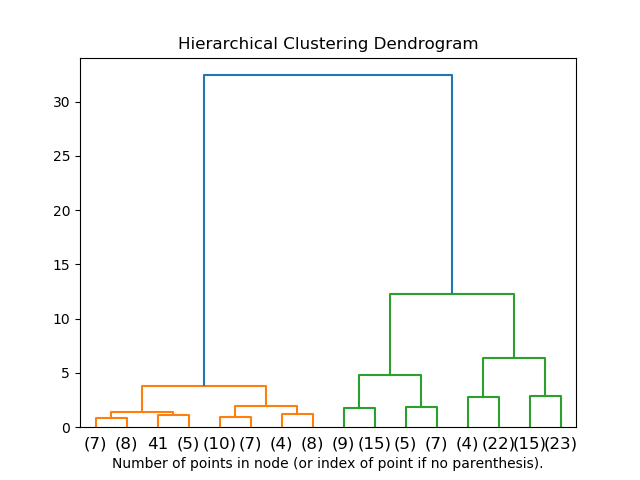

In [61]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import load_iris


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


iris = load_iris()
X = iris.data

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()